In [1]:
# Data based on:
# https://doi.org/10.1016/j.ymben.2014.07.004
# Libraries for the Dynamic block
import numpy as np
from scipy.integrate import odeint
# Libraries for the Metabolic block
import cobra
model=cobra.io.read_sbml_model("iMM904.xml")
# Plotting libraries
import matplotlib.pyplot as plt

In [2]:
# Kinetic block
def kineticBlock(Glu,Eth):
    # Parameters
    vGmax, K_Glu, K_Eth = 22.5, 0.88, 6.74
    f_Eth,f_Gly, f_Cit, f_Lac = .112, .273, .169, .137
    v_Glu=vGmax*Glu/(K_Glu+Glu)*1/(1+Eth/K_Eth)
    LB_Eth = -v_Glu*f_Eth
    LB_Gly = -v_Glu*f_Gly
    LB_Cit = -v_Glu*f_Cit
    LB_Lac = -v_Glu*f_Lac
    #LB_ATP_Ex = m_ATP
    return [v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac]

# Metabolic block
def metabolicBlock(v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac):
    if abs(v_Glu)>1e-4:   
        model.reactions.get_by_id("EX_glc__D_e").bounds = (-v_Glu,-v_Glu) # set flux of glucose
        #model.reactions.get_by_id("EX_etoh_e").lower_bound   = LB_Eth
        #model.reactions.get_by_id("EX_glyc_e").lower_bound   = LB_Gly
        #model.reactions.get_by_id("EX_cit_e").lower_bound    = LB_Cit
        #model.reactions.get_by_id("EX_lac__D_e").lower_bound = LB_Lac
        # The same for Eth, Gly, Cit, Lac

        solution = model.optimize()
        u = solution.objective_value
        v_Eth = model.reactions.get_by_id("EX_etoh_e").x
        v_Gly = model.reactions.get_by_id("EX_glyc_e").x
        v_Cit = model.reactions.get_by_id("EX_cit_e").x
        v_Lac = model.reactions.get_by_id("EX_lac__D_e").x
    else:
        u, v_Eth, v_Gly, v_Cit, v_Lac = 0,0,0,0,0
    return [u, v_Eth, v_Gly, v_Cit, v_Lac]
    
# Dynamic block
def f(y,t,params):
    V,VX,VGlu,VEth,VGly,VCit,VLac = y # Current values
    F,u, v_Glu, v_Eth, v_Gly, v_Cit, v_Lac = params  # unpack parameters
    Glu_F = 200
    MW_Glu,MW_Eth,MW_Gly,MW_Cit,MW_Lac = [0.18,.046,.092,.192,.090] #Molecular weights
    derivs=[F,                  # dV/dt
            u*VX,                # dVX/dt
            F*Glu_F-v_Glu*MW_Glu*(VX), # dVGlu/dt
            v_Eth*MW_Eth*(VX), # dVEth/dt
            v_Gly*MW_Gly*(VX), # dVGly/dt
            v_Cit*MW_Cit*(VX), # dVCit/dt
            v_Lac*MW_Lac*(VX)] # dVLac/dt
    return derivs
def dynamicBlock(y,params, ti,tf):
    time=np.linspace(ti,tf,100)
    #F,u,v_Glu, v_Eth, v_Gly, v_Cit, v_Lac = params
    soln = odeint(f,y,time,args=(params,))
    # Get solutions at the final time point (tf):
    V=soln[-1,0]
    X,Glu,Eth,Gly,Cit,Lac=soln[-1,1:7]/V
    return [V,X,Glu,Eth,Gly,Cit,Lac]    


# Save results along the fermentation path

def savePath(u,V,X,Glu,Eth,Gly,Cit,Lac,v_Glu):
    global u_path,V_path,X_path
    global Glu_path,Eth_path,Gly_path,Cit_path,Lac_path
    global v_Glu_path
    u_path += [u]
    V_path += [V]
    X_path += [X]
    Glu_path += [Glu]
    Eth_path += [Eth]
    Gly_path += [Gly]
    Cit_path += [Cit]
    Lac_path += [Lac]
    v_Glu_path += [v_Glu]

In [3]:
# Initial conditions
Glu=20
Eth,Gly,Cit,Lac=[0,0,0,0]
V,X=[0.5,0.5]
F=0.0

u_path,V_path,X_path = [],[],[]
Glu_path,Eth_path,Gly_path,Cit_path,Lac_path = [],[],[],[],[]
v_Glu_path=[]
# Running the simulation over time
time=np.linspace(0,22,200)
for i in range(len(time)):
    # KINETIC BLOCK: 
    # given the current concentrations of glucose (Glu) and ethanol (Eth)
    # we compute the fluxes of Glu, and upper and lower limits of Eth, Glycerol(Gly), Citrate(Cit), and Lactate(Lac)
    v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac = kineticBlock(Glu,Eth)
    # METABOLIC BLOCK
    # given v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac
    # we compute biomass growth rate (u) and metabolic fluxes of extracellular metabolites
    u,v_Eth, v_Gly, v_Cit, v_Lac = metabolicBlock(v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac)
    # DYNAMIC BLOCK
    # given u, V, fluxes (v_Eth, v_Gly, v_Cit, v_Lac), and concentrations (X,Glu,Eth,Gly,Cit,Lac)
    # we update reaction volume V, X and Glu,Eth,Gly,Cit,Lac
    if i==len(time)-1: continue
    y = [V,X*V,Glu*V,Eth*V,Gly*V,Cit*V,Lac*V]
    params = [F,u,v_Glu, v_Eth, v_Gly, v_Cit, v_Lac]
    V,X,Glu,Eth,Gly,Cit,Lac = dynamicBlock(y, params, time[i],time[i+1])
    # Save results along the fermentaion path
    savePath(u,V,X,Glu,Eth,Gly,Cit,Lac,v_Glu)

/usr/local/lib/python3.7/dist-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


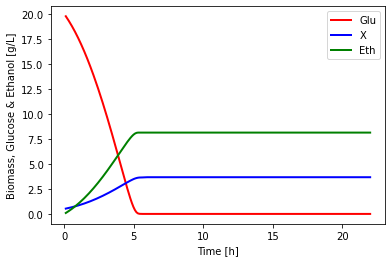

In [4]:
plt.plot(time[1:600],Glu_path,'r',linewidth=2,label='Glu')
plt.plot(time[1:600],X_path,'b',linewidth=2,label='X')
plt.plot(time[1:600],Eth_path,'g',linewidth=2,label='Eth')
plt.legend()
plt.ylabel('Biomass, Glucose & Ethanol [g/L]')
plt.xlabel('Time [h]')
plt.show()

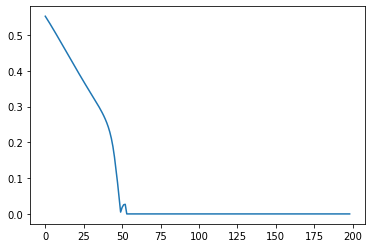

In [5]:
plt.plot(u_path)

In [6]:
u_path

[0.5522396242891339,
 0.5454911589441201,
 0.5386165859541039,
 0.5316280162034372,
 0.5245380572165025,
 0.5173596803772722,
 0.5101060848825639,
 0.5027905598121223,
 0.49542634694275595,
 0.4880265067323024,
 0.4806037896024313,
 0.4731705142713655,
 0.46573845468013675,
 0.4583187352231731,
 0.45092173668215335,
 0.44338578851585086,
 0.4358771561007566,
 0.4284179965699417,
 0.4210152671552482,
 0.4135781582212364,
 0.40610104226488336,
 0.39869558423960594,
 0.3912883677365889,
 0.38394511318911556,
 0.3766762461486484,
 0.36947911640071557,
 0.3623490425757477,
 0.35527902566623076,
 0.3482593615615461,
 0.3412771139600601,
 0.3343153913128307,
 0.32735234655958295,
 0.3203423307903014,
 0.3132317004651413,
 0.30600636569633133,
 0.29860295635516587,
 0.29093658756246943,
 0.2828916357792449,
 0.2743076082769614,
 0.2649571424720898,
 0.25451140064892386,
 0.24248576399517105,
 0.2281578646910199,
 0.21046063229011405,
 0.18791774632235864,
 0.15894941601545534,
 0.1235691413731

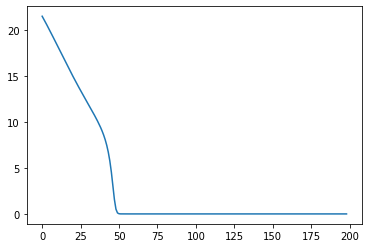

In [7]:
plt.plot(v_Glu_path)

In [8]:
v_Glu_path

[21.551724137931036,
 21.246606010483198,
 20.935786182495654,
 20.619812222958743,
 20.299254155430976,
 19.974698454642066,
 19.646741895415655,
 19.315985316449183,
 18.98302741773396,
 18.64845870129316,
 18.31285565149534,
 17.976775234116516,
 17.640749783940382,
 17.305282267822882,
 16.970842031682686,
 16.63786092971062,
 16.306709675937977,
 15.977740311855833,
 15.651259670442622,
 15.32752423688258,
 15.006725446375544,
 14.689001073565565,
 14.374446594627882,
 14.063083472313782,
 13.754874472779038,
 13.44970722363513,
 13.147383228992213,
 12.847605722230169,
 12.549963236994133,
 12.253907258011814,
 11.95872156260759,
 11.663479808264492,
 11.366986271024391,
 11.067689979971801,
 10.76356561981959,
 10.451945853972045,
 10.129257760150516,
 9.790634583257706,
 9.42932096178642,
 9.035746889300935,
 8.596071130331433,
 8.08989540702335,
 7.486814256097249,
 6.741913202706086,
 5.793051870976159,
 4.573734676526529,
 3.0845298532378114,
 1.566022625743933,
 0.516943416

In [9]:
model.medium

{'EX_fe2_e': 999999.0,
 'EX_glc__D_e': 0.00047778629008562626,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_so4_e': 999999.0,
 'EX_nh4_e': 999999.0,
 'EX_o2_e': 2.0,
 'EX_pi_e': 999999.0}

In [10]:
v_Glu =  -1e-200
model.reactions.get_by_id("EX_glc__D_e").bounds = (v_Glu,v_Glu)
sln=model.optimize()

/usr/local/lib/python3.7/dist-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [11]:
sln.objective_value

0.027048231189739026

In [12]:
v_Glu

-1e-200

# Tarea:
    
Utilizar el oxigeno en lugar de la glucosa como sustrato limitante. Podemos experimentar con una cinética de tipo Michaelis-Menten.

$v_{O_2} = v_M^{O_2} \frac{O_2}{K_{O_2}+O_2}$